In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import xgboost as xgb

In [2]:
from sklearn.metrics import mean_absolute_error
from datetime import date

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import matplotlib.pyplot as plt

In [5]:
# set the seed of random number generator, which is useful for creating simulations 
# or random objects that can be reproduced.
import random
SEED=3
random.seed(SEED)
np.random.seed(SEED)

In [6]:
# Load Train Data
train = pd.read_pickle('../data/processed/train_x_envios_feateng.pkl')

In [7]:
train.shape

(34183, 95)

In [8]:
train['fecha_venta_norm'] = pd.to_datetime(train['fecha_venta_norm'])

In [9]:
train['fecha_venta_norm'] = train['fecha_venta_norm'].dt.date

In [10]:
predictors = [
    'id_pos', 
    'canal',
    'competidores',
    'ingreso_mediana',
    'ingreso_promedio',
    'densidad_poblacional',
    'pct_0a5',
    'pct_5a9',
    'pct_10a14',
    'pct_15a19',
    'pct_20a24',
    'pct_25a29',
    'pct_30a34',
    'pct_35a39',
    'pct_40a44',
    'pct_45a49',
    'pct_50a54',
    'pct_55a59',
    'pct_60a64',
    'pct_65a69',
    'pct_70a74',
    'pct_75a79',
    'pct_80a84',
    'pct_85ainf',
    'pct_bachelors',
    'pct_doctorados',
    'pct_secundario',
    'pct_master',
    'pct_bicicleta',
    'pct_omnibus',
    'pct_subtes',
    'pct_taxi',
    'pct_caminata',
    'mediana_valor_hogar',
    'unidades_despachadas_sum', 
    'unidades_despachadas_max',
    'unidades_despachadas_min', 
    'unidades_despachadas_avg',
    'cantidad_envios_max', 
    'cantidad_envios_min', 
    'cantidad_envios_avg',
    'num_cantidad_envios', 
    'unidades_despachadas_sum_acum', 
    'unidades_despachadas_sum_acum_3p',
    'unidades_despachadas_sum_acum_6p', 
    'unidades_despachadas_max_acum', 
    'unidades_despachadas_min_acum', 
    'num_cantidad_envios_acum', 
    'num_cantidad_envios_acum_3per',
    'num_cantidad_envios_acum_6per', 
    'diff_dtventa_dtenvio',
    'unidades_before', 
    'num_ventas_before',
    'rel_unidades_num_ventas', 
    'unidades_acum', 
    'num_ventas_acum',
    'countacum', 'unidades_mean', 
    'num_ventas_mean',
    'unidades_2time_before', 
    'unidades_diff', 
    'month',
    'diff_dtventa_dtventa_before', 
    'unidades_pend',
    'unidades'
]

In [11]:
train = train[predictors]

#### encode catvars

In [12]:
le = preprocessing.LabelEncoder()

In [13]:
le.fit(train['canal'].unique())

LabelEncoder()

In [14]:
train['canal'] = le.transform(train['canal'].values)

In [15]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]


In [16]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Hyperparameters tuning

In [18]:
## =========================================================================================================
# 
#  Booster Parameters 
#
# n_estimators
#    - The number of sequential trees to be modeled
#    - Though GBM is fairly robust at higher number of trees but it can still overfit at a point.
#
# max_depth [default=6]
#    - The maximum depth of a tree.
#    - Used to control over-fitting as higher depth will allow model to learn relations very pecific to a particular sample.
#    - Typical values: 3-10
#
# min_child_weight [default=1]
#    - Defines the minimum sum of weights of all observations required in a child.
#    - This is similar to min_child_leaf in GBM but not exactly.
#      This refers to min sum of weightsof observations while GBM has min number of observations.
#    - Used to control over-fitting. Higher values prevent a model from learning relations
#      which might be highly specific to the particular sample selected for a tree.
#    - Too high values can lead to under-fitting hence, it should be tuned using CV.
#
# eta : learning rate
#   - Makes the model more robust by shrinking the weights on each step
#   - Typical final values to be used: 0.01-0.2
#
# gamma [default=0]
#
#    - A node is split only when the resulting split gives a positive reduction in the loss function.
#    - Gamma specifies the minimum loss reduction required to make a split.
#    - Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
#
# subsample [default=1]
#     - Denotes the fraction of observations to be randomly samples for each tree.
#     - Lower values make the algorithm more conservative and prevents overfitting but too small values
#       might lead to under-fitting.
#     - Typical values: 0.5-1
#
# colsample_bytree [default=1]
#     - Denotes the fraction of columns to be randomly samples for each tree.
#     - Typical values: 0.5-1
#
# alpha [default=0]
#     - L1 regularization term on weight (analogous to Lasso regression)
#     - Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
#
# scale_pos_weight [default=1]
#     A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
#
## ===========================================================================================================


#### Number of trees (estimators)

In [19]:
# 5 fold cross validation is more accurate than using a single validation set
cv_folds = 5
early_stopping_rounds = 50
model = xgb.XGBRegressor(seed = SEED)

In [20]:
xgb_param = model.get_xgb_params()

In [21]:
xgb_param

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 3,
 'subsample': 1,
 'verbosity': 1}

In [22]:
# To train on GPU
xgb_param['objective'] = 'reg:squarederror'
xgb_param['gpu_id'] = 0
xgb_param['max_bin'] = 16
xgb_param['tree_method'] = 'gpu_hist'
xgb_param['learning_rate'] = 0.01

In [23]:
cvresult = xgb.cv(params=xgb_param, dtrain=data_dmatrix, num_boost_round = 1000, nfold = cv_folds, metrics = 'mae', early_stopping_rounds = early_stopping_rounds, seed = SEED)
print(cvresult)
print ("Optimal number of trees (estimators) is %i" % cvresult.shape[0])

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         16.996942       0.065061      16.996178      0.260002
1         16.827683       0.064313      16.826592      0.257005
2         16.660298       0.063513      16.658926      0.254936
3         16.495076       0.062743      16.493558      0.252007
4         16.332416       0.061705      16.330890      0.250181
5         16.172799       0.060925      16.171397      0.247527
6         16.016077       0.059897      16.014425      0.245859
7         15.863063       0.058540      15.861518      0.243481
8         15.711118       0.057864      15.709253      0.241695
9         15.560974       0.056823      15.559454      0.240225
10        15.413309       0.056899      15.411897      0.237793
11        15.266619       0.055679      15.265565      0.236694
12        15.123474       0.055923      15.122809      0.234106
13        14.984010       0.055471      14.983577      0.232073
14        14.852523       0.054278      

In [24]:
model.set_params(objective = 'reg:squarederror')
model.set_params(gpu_id = 0)
model.set_params(max_bin= 16)

model.set_params(learning_rate = 0.01)
model.set_params(n_estimators=1000)
model.set_params(tree_method='gpu_hist')

model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=3, silent=None, subsample=1,
       tree_method='gpu_hist', verbosity=1)

Text(0, 0.5, 'Feature Importance Score')

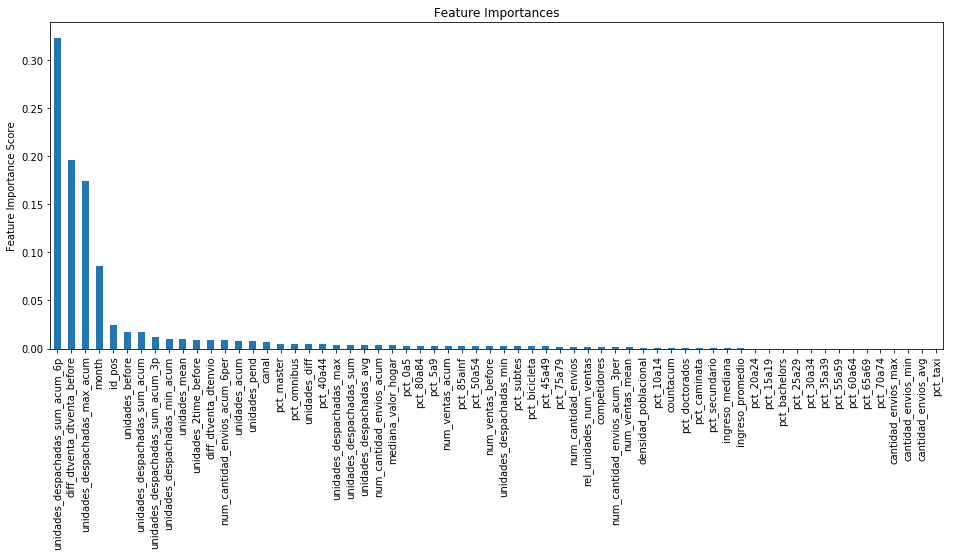

In [25]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(16,6))
plt.ylabel('Feature Importance Score')

#### max_depth & min_child_weight

In [26]:
model.set_params(objective = 'reg:squarederror')
model.set_params(gpu_id = 0)
model.set_params(max_bin= 16)

model.set_params(learning_rate = 0.01)
model.set_params(n_estimators=1000)
model.set_params(tree_method='gpu_hist')


param_test1 = {
'max_depth': [i for i in range(2,8,1)],
'min_child_weight': [i for i in range(1,6,1)]
}

In [27]:
gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring = 'neg_mean_absolute_error',  iid = False, cv = cv_folds, verbose = 1)

In [28]:
res =gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 20.5min finished


In [29]:
#print gsearch1.grid_scores_
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 7, 'min_child_weight': 4}
-5.576470857893801


#### gamma

In [30]:
model.set_params(max_depth = 7)
model.set_params(min_child_weight = 4)

param_test2 = {
'gamma':[i/10.0 for i in range(0,5)]
}


In [31]:
gsearch2 = GridSearchCV(estimator = model, param_grid = param_test2, scoring = 'neg_mean_absolute_error',  iid = False, cv = cv_folds, verbose = 1)
gsearch2.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimators=1...1, scale_pos_weight=1, seed=3, silent=None, subsample=1,
       tree_method='gpu_hist', verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [32]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'gamma': 0.0}
-5.576470857893801


#### Recal number of trees (estimators)

In [19]:
# 5 fold cross validation is more accurate than using a single validation set
cv_folds = 5
early_stopping_rounds = 50
model = xgb.XGBRegressor(seed = SEED)

In [20]:
xgb_param = model.get_xgb_params()

In [21]:
# To train on GPU
xgb_param['objective'] = 'reg:squarederror'
xgb_param['gpu_id'] = 0
xgb_param['max_bin'] = 16
xgb_param['tree_method'] = 'gpu_hist'
xgb_param['learning_rate'] = 0.01
xgb_param['gamma'] = 0.0
xgb_param['max_depth'] = 7
xgb_param['min_child_weight'] = 4

In [22]:
cvresult = xgb.cv(params=xgb_param, dtrain=data_dmatrix, num_boost_round = 1000, nfold = cv_folds, metrics = 'mae', early_stopping_rounds = early_stopping_rounds, seed = SEED)
print(cvresult)
print ("Optimal number of trees (estimators) is %i" % cvresult.shape[0])

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         16.997697       0.065034      16.997463      0.260372
1         16.828657       0.064343      16.828224      0.257683
2         16.661378       0.063660      16.660743      0.255031
3         16.495951       0.062987      16.495135      0.252511
4         16.332359       0.062283      16.331143      0.249874
5         16.170497       0.061636      16.169159      0.247268
6         16.010664       0.061072      16.009269      0.244700
7         15.852994       0.060512      15.851453      0.242255
8         15.697456       0.059867      15.695982      0.239872
9         15.543846       0.059136      15.542439      0.237438
10        15.392373       0.058290      15.390947      0.235286
11        15.242987       0.057571      15.241646      0.232983
12        15.095462       0.056899      15.094234      0.230979
13        14.949644       0.056326      14.948698      0.228751
14        14.805946       0.055642      

- N_estimators = 1000. Se encontro un mejor numero de estimadores

#### subsample & colsample_bytree

In [23]:
model.set_params(objective = 'reg:squarederror')
model.set_params(gpu_id = 0)
model.set_params(max_bin= 16)
model.set_params(tree_method='gpu_hist')
model.set_params(learning_rate = 0.01)
model.set_params(n_estimators = 651)
model.set_params(max_depth = 7)
model.set_params(min_child_weight = 4)
model.set_params(gamma = 0.0)



param_test3 = {
'subsample' : [i/10.0 for i in range(6,11)],
'colsample_bytree' : [i/10.0 for i in range(6,11)]
}


In [24]:
gsearch3 = GridSearchCV(estimator = model, param_grid = param_test3, scoring = 'neg_mean_absolute_error',  iid = False, cv = cv_folds, verbose = 1)
gsearch3.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 16.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimators...1, scale_pos_weight=1, seed=3, silent=None, subsample=1,
       tree_method='gpu_hist', verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [25]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'colsample_bytree': 0.7, 'subsample': 0.9}
-5.533399801184162


#### shrinking subsample & colsample_bytree

In [26]:
model.set_params(objective = 'reg:squarederror')
model.set_params(gpu_id = 0)
model.set_params(max_bin= 16)
model.set_params(tree_method='gpu_hist')
model.set_params(learning_rate = 0.01)
model.set_params(n_estimators = 939)
model.set_params(max_depth = 5)
model.set_params(min_child_weight = 5)
model.set_params(gamma = 0.0)


param_test3 = {
'subsample' : [i/100.0 for i in range(95,100,1)],
'colsample_bytree' : [i/100.0 for i in range(65,76,1)]
}

In [27]:
gsearch3 = GridSearchCV(estimator = model, param_grid = param_test3, scoring = 'neg_mean_absolute_error',  iid = False, cv = cv_folds, verbose = 1)
gsearch3.fit(X_train,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed: 30.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators...1, scale_pos_weight=1, seed=3, silent=None, subsample=1,
       tree_method='gpu_hist', verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'subsample': [0.95, 0.96, 0.97, 0.98, 0.99], 'colsample_bytree': [0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [29]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'colsample_bytree': 0.66, 'subsample': 0.95}
-7.644157605361481


#### reg_alpha

In [28]:
model.set_params(objective = 'reg:squarederror')
model.set_params(gpu_id = 0)
model.set_params(max_bin= 16)
model.set_params(tree_method='gpu_hist')
model.set_params(learning_rate = 0.01)
model.set_params(n_estimators = 651)
model.set_params(max_depth = 7)
model.set_params(min_child_weight = 4)
model.set_params(gamma = 0.0)
model.set_params(colsample_bytree = 0.7)
model.set_params(subsample = 0.9)


param_test4 = {
'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}



In [29]:
gsearch4 = GridSearchCV(estimator = model, param_grid = param_test4, scoring = 'neg_mean_absolute_error',  iid = False, cv = cv_folds, verbose = 1)
gsearch4.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimato... scale_pos_weight=1, seed=3, silent=None,
       subsample=0.9, tree_method='gpu_hist', verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [30]:
print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'reg_alpha': 0.01}
-5.534888525528238


#### Training and Testing Model

In [18]:
model = xgb.XGBRegressor(seed = SEED)

In [19]:
model.set_params(objective = 'reg:squarederror')
model.set_params(gpu_id = 0)
model.set_params(max_bin= 16)
model.set_params(tree_method='gpu_hist')
model.set_params(learning_rate = 0.01)
model.set_params(n_estimators = 651)
model.set_params(max_depth = 7)
model.set_params(min_child_weight = 4)
model.set_params(gamma = 0.0)
model.set_params(colsample_bytree = 0.7)
model.set_params(subsample = 0.9)
model.set_params(reg_alpha = 0.01)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimators=651, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=0, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=3, silent=None,
       subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [20]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=0,
       importance_type='gain', learning_rate=0.01, max_bin=16,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimators=651, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=0, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=3, silent=None,
       subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [21]:
y_pred = model.predict(X_test)

In [22]:
print("MAE unidades: ",mean_absolute_error(y_test, y_pred))

MAE unidades:  5.4995786875281505


In [23]:
print("mean unidades pred: ", np.mean(y_pred))

mean unidades pred:  17.76847


In [24]:
print("median unidades pred: ", np.median(y_pred))

median unidades pred:  9.240887


Text(0, 0.5, 'Feature Importance Score')

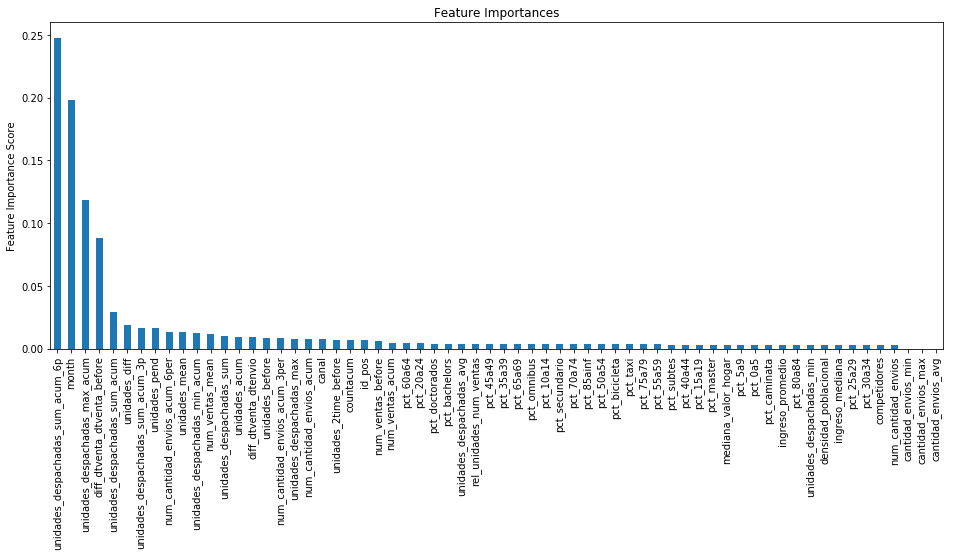

In [25]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(16,6))
plt.ylabel('Feature Importance Score')